B_predict tries to anticipate the response of B_late, which associates some value to the key in A, but with some fixed delay. To do that, we learn the conenction A->B_predict with an error function that minimizes the difference between B_late and B_predict. The problem is that the predictor unlearns all the time because the error function is nonzero when A is active before B_late (i.e. is delayed) and when B_late is active when A is not anymore. Here, we try with STDP. It should be more suitable than PES because learning only occurs when both populations are spiking (I think).

In [1]:
import nengo
import nengo_dl
import nengo_spa as spa
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from stdp import STDP

class Cycler():
    def __init__(
        self, 
        SPs, 
        relative_start,
        relative_stop,
        SP_duration,
        t_stop
    ):
        assert relative_start <= relative_stop
        self.SPs = SPs
        self.start = relative_start * SP_duration
        self.stop = relative_stop * SP_duration
        self.SP_duration = SP_duration
        self.t_stop = t_stop
        

    def make_step(self):
        def f(t,x):
            t_in_window = t % self.SP_duration
            idx = int((t % (self.SP_duration*len(self.SPs))) // self.SP_duration)
            if t_in_window>self.start and t_in_window<self.stop and t<self.t_stop:
                return self.SPs[idx]
            else:
                return "0"
        return f
    
n_SPs = 3
D = 32
subdimensions = D
n_neurons = 30*subdimensions
intercepts = nengo.dists.Uniform(.1, .1)

vocab = spa.Vocabulary(D)
SPs = ['SP'+str(i) for i in range(n_SPs)]
vocab.populate(';'.join(SPs))

In [2]:
with spa.Network() as model:
    
    SP_duration = .5
    n_training_cycles = 4
    T_learning = SP_duration * n_training_cycles * n_SPs

    A_f = Cycler(SPs, .25, .75, SP_duration, n_SPs*999).make_step()
    A = nengo.Ensemble(
        30*D,
        D,
        intercepts=intercepts
    )
    A_inp = spa.Transcode(A_f, input_vocab=vocab, output_vocab=vocab)
    nengo.Connection(A_inp.output, A)
    A_out = spa.Transcode(input_vocab=vocab, output_vocab=vocab)
    nengo.Connection(A, A_out.input)

    B_f = Cycler(np.roll(SPs,-1), .5, 1, SP_duration, n_SPs*n_training_cycles).make_step()
    B = nengo.Ensemble(
        30*D,
        D,
        intercepts=intercepts
    )
    B_inp = spa.Transcode(B_f, input_vocab=vocab, output_vocab=vocab)
    nengo.Connection(B_inp.output, B)
    B_out = spa.Transcode(input_vocab=vocab, output_vocab=vocab)
    nengo.Connection(B, B_out.input)
        
    connection = nengo.Connection(
            A.neurons,
            B.neurons,
            transform=np.zeros((B.n_neurons, A.n_neurons)),
#             learning_rule_type=STDP(
#                 bounds="none",
            learning_rule_type=nengo.BCM(
                learning_rate=5e-12 #/ B.n_neurons, # see notes in https://www.nengo.ai/nengo/frontend-api.html?highlight=bcm#nengo.BCM
            ),
    )
        
    # Setup probes
    p_A_in = nengo.Probe(A_inp.output, synapse=.005)
    p_B_in = nengo.Probe(B_inp.output, synapse=.005)
    p_A = nengo.Probe(A_out.output, synapse=.005)
    p_B = nengo.Probe(B_out.output, synapse=.005)
        

In [3]:
T = T_learning
with nengo_dl.Simulator(model) as sim:
    sim.run(T)

|#####################Building network (55%)                     | ETA: 0:00:00

/home/hugo/.env/main/lib/python3.8/site-packages/nengo_dl/simulator.py:460: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Build finished in 0:00:00                                                      :00
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Simulation finished in 0:00:23                                                 


In [4]:
def plot_similarities(
    t_range, data, vocab, title='', autoscale=False
):

    ymin, ymax = -.5, 1.5
    plt.ylim(ymin, ymax)
    if autoscale:
        plt.autoscale(autoscale, axis="y")
    plt.plot(t_range, spa.similarity(data, vocab))
    plt.title(title)
#     plt.xlabel("Time")
    plt.xlim(left=T-n_SPs*SP_duration*2, right=t_range[-1])
#     plt.legend(
#         list(vocab.keys()), loc="upper center", bbox_to_anchor=(0.5, -0.13), ncol=3
#     )

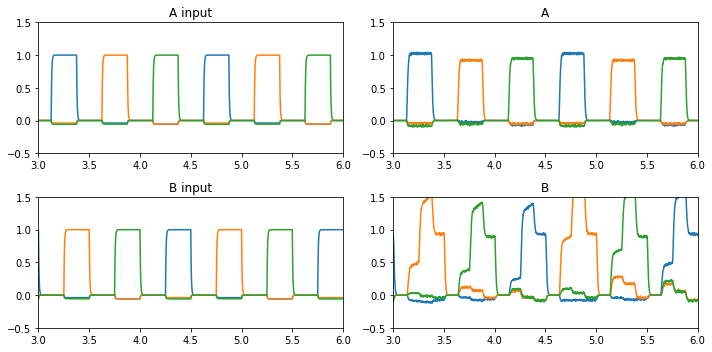

In [5]:
plt.figure(figsize=(5*2, 5))
plt.subplot(2, 2, 1)
plot_similarities(sim.trange(), sim.data[p_A_in], vocab, 'A input')
plt.subplot(2, 2, 2)
plot_similarities(sim.trange(), sim.data[p_A], vocab, 'A')
plt.subplot(2, 2, 3)
plot_similarities(sim.trange(), sim.data[p_B_in], vocab, 'B input')
plt.subplot(2, 2, 4)
plot_similarities(sim.trange(), sim.data[p_B], vocab, 'B')

plt.tight_layout()
